In [44]:
import sys, copy, os
import numpy as np

from LGR.plotting import *
from Flows.Flows import *

In [45]:
# Generate structured trajectory data for the double gyre flow

# Flow type and duration:
flowname = "Gyre"
n_steps = 200
dt = 0.05    

# optional parameters
parameters = {  # These are specified as defaults as well. 
    "A": 0.1,
    "epsilon": 0.1,
    "omega":2*np.pi/10
}

# Initialize the flow 
flow = Flow()

# Now, make vectors associated with each axis.
domain = np.array([[0, 2],[0, 1]])
n_y = 50            # number of rows
n_x = 2*n_y         # number of columns
eps = 0.0001        # for visualization
y_vec = np.linspace(domain[1,0]+eps, domain[1,1]-eps, n_y)     # 25 rows
x_vec = np.linspace(domain[0,0]+eps, domain[0,1]-eps, n_x)     # 50 columns

# Then, make the mesh grid and flatten it to get a single vector of positions.  
mesh = np.meshgrid(x_vec, y_vec)
x = mesh[0].reshape(-1,1)
y = mesh[1].reshape(-1,1)
ICs = np.append(x, y, axis=1)

# Generate a time vector
tvec = np.linspace(0, dt*n_steps, n_steps) 

# Generate the trajectories
flow.predefined_function(flowname, ICs, tvec, parameters=parameters, include_gradv=True)
flow.integrate_trajectories()
trajectories = flow.states

In [46]:
# Define functions to compute flow map jacobians along a trajectory

# Compute the flow map jacobian for a single time step from the velocity gradient
def computeFMJ(pos, time, dt, gradient_function):
    return gradient_function(pos, time)*dt + np.eye(len(pos))

# Accumulate short-time jacobians using composition
def processTrajectory(trajectory, times, gradient_function):
    
    assert(len(trajectory) == len(times))
    
    jacobian = np.eye(len(trajectory[0]))
    for i in range(len(times)-1):
        t0 = times[i]
        dt = times[i+1]-t0
        pos0 = trajectory[i]
        gradF = computeFMJ(pos0, t0, dt, gradient_function)
        
        jacobian = gradF @ jacobian
    
    return jacobian

# Compute the ftle from a jacobian.
def computeFTLE(jacobian, dt):
    U, S, VT = np.linalg.svd(jacobian)
    lam_max = S[0]
    return 1/np.abs(dt)*np.log(lam_max)

In [47]:
# Compute the ftle for every trajectory (using only that trajectory)
ftle = np.zeros((np.shape(trajectories)[0],1))
for i in range(np.shape(trajectories)[0]):
    traj = trajectories[i,:,:].squeeze()
    jacobian = processTrajectory(traj, tvec, flow.gradv_function)
    ftle[i] = computeFTLE(jacobian, tvec[-1] - tvec[0])
    
# format as a field for plotting
ftle_field = ftle.reshape(np.shape(mesh[0]))

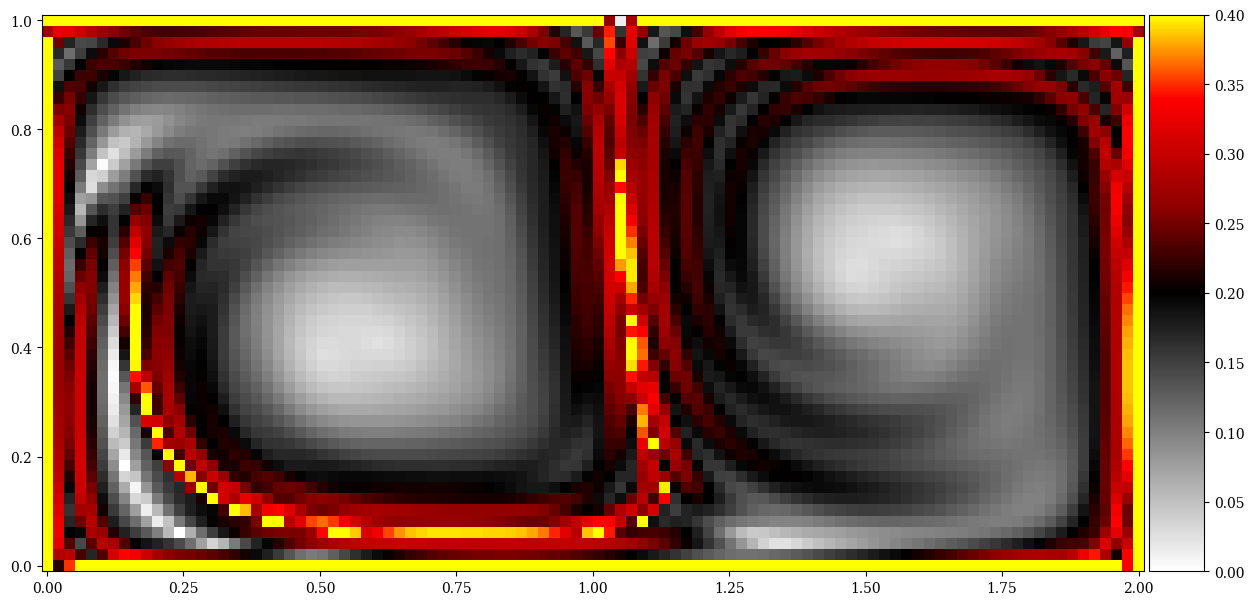

In [48]:
# Plot the ftle field
clim = [0, 0.4]
fig, ax = plt.subplots()
ftleim = ax.pcolormesh(mesh[0], mesh[1], ftle_field, cmap='gray2hot', vmin=clim[0], vmax=clim[1])
ax.axis('scaled')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ftleim, cax=cax)
plt.show()